In [1]:
!pip install "gluonts[torch]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 25.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [6]:
# fill null dates with LOCF
'''# Load data from CSV files
df = pd.read_csv("DCCrho_data.csv", index_col=0, parse_dates=True)

# If your index is not a datetime type, convert it to datetime
df.index = pd.to_datetime(df.index)

# For example, if your data is daily, set the frequency to 'D'
df = df.asfreq('D')

# Fill missing values using LOCF (Last Observation Carried Forward)
df = df.fillna(method='ffill')'''

In [174]:
# fill null dates with splines
import pandas as pd
from scipy.interpolate import UnivariateSpline

# Load data from CSV files
df = pd.read_csv("DCCrho_data.csv", index_col=0, parse_dates=True)

# If your index is not a datetime type, convert it to datetime
df.index = pd.to_datetime(df.index)

# Filter data for years 2021, 2022, and 2023
#df = df["2020":"2023"]

# For example, if your data is daily, set the frequency to 'D'
df = df.asfreq('D')


def fill_missing_with_spline(series):
    # Extract indices of null values
    null_indices = series[series.isnull()].index
    # Extract non-null values
    non_null_values = series.dropna()
    # Create spline interpolation object with specified s value
    spline = UnivariateSpline(non_null_values.index.astype(int), non_null_values.values, s=2)
    # Interpolate null values
    interpolated_values = spline(null_indices.astype(int))
    # Replace null values with interpolated values
    series.loc[null_indices] = interpolated_values
    return series


'''# Fill missing values using spline interpolation
def fill_missing_with_spline(series):
    # Extract non-missing values
    known_values = series.dropna()
    # Create spline interpolation object
    spline = UnivariateSpline(known_values.index.astype(int), known_values.values, s=0)
    # Interpolate missing values
    interpolated_values = spline(series.index.astype(int))
    return pd.Series(interpolated_values, index=series.index)'''

# Apply spline interpolation to each column of the DataFrame
df = df.apply(fill_missing_with_spline, axis=0)

# Convert the DataFrame into a PandasDataset
dataset = PandasDataset(
    dataframes=df,
    target="DCCrho"
)


In [175]:
df

,DCCrho
Date,
2018-01-03,0.663214
2018-01-04,0.669492
2018-01-05,0.671036
2018-01-06,0.646540
2018-01-07,0.654815
...,...
2023-12-24,0.567170
2023-12-25,0.578769
2023-12-26,0.546226


In [176]:
from gluonts.dataset.split import split

training_data, test_gen = split(dataset, offset=-240)

test_data = test_gen.generate_instances(prediction_length=20, windows=12)


In [177]:
# Train the model and make predictions
model = DeepAREstimator(
    prediction_length=20, freq="D", dropout_rate = 0.5, num_layers = 3, lr = 0.04, trainer_kwargs={"max_epochs": 10}
).train(training_data)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name  | Type        | Params | In sizes                                                         | Out sizes   
------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 39.0 K | [[1, 1], [1, 1], [1, 1102, 4], [1, 1102], [1, 1102], [

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached -1.35307 (best -1.35307), saving model to '/content/lightning_logs/version_31/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.35307 (best -1.35307), saving model to '/content/lightning_logs/version_31/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -1.77994 (best -1.77994), saving model to '/content/lightning_logs/version_31/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.77994 (best -1.77994), saving model to '/content/lightning_logs/version_31/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' was not in top 1
INFO: Epoch 3, global step 200: 'train_loss' reached -1.84218 (best -

In [178]:
forecasts = list(model.predict(test_data.input))


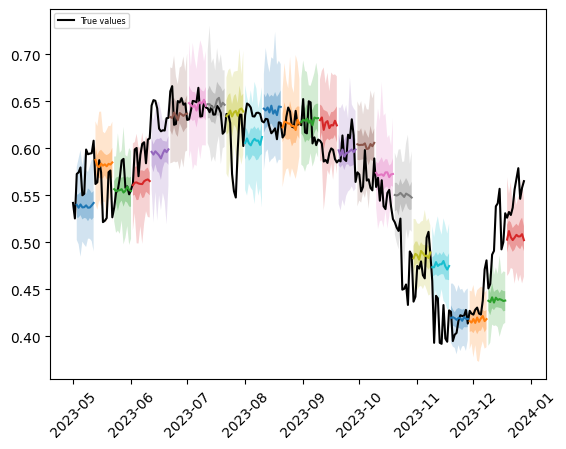

In [179]:
# Plot predictions
plt.plot(df["2023-05":], color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-small")
plt.xticks(rotation=45)
plt.show()